<a href="https://colab.research.google.com/github/Ksenyff/ICV-2024/blob/main/Week_4_Spiridonova_K_O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4. Image Filtering and Noise Reduction

In [ ]:
# Import necessary libraries
import cv2
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from typing import Tuple, List

plt.rcParams['axes.titlesize'] = 10

## Preparations

In [ ]:
def add_gaussian_noise(image: np.ndarray,
                       mean: float = 0, sigma: float = 16,
                       vmax: int = 255) -> np.ndarray:
  """
  Adds Gaussian noise to a grayscale image.

  Parameters:
    image (np.ndarray): Input grayscale image.
    mean (float): Mean of the Gaussian noise distribution. Default is 0.
    sigma (float): Standard deviation of the Gaussian noise distribution. Default is 16.
    vmax (int): Maximum pixel intensity value (depends on image depth).
                Default is 255 for 8-bit images.

  Returns:
    np.ndarray: Image with added Gaussian noise, clipped to the valid range [0, vmax].
  """
  # Generate Gaussian noise with the specified mean and standard deviation
  gaussian_noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)

  # Add the generated noise to the image
  # Q: How do we handle overflow and underflow of pixel values?
  image_noisy = image.astype(np.float32) + gaussian_noise

  # Clip the pixel values to ensure they stay within the valid range [0, vmax]
  image_noisy = np.clip(image_noisy, 0, vmax)

  return image_noisy.astype(image.dtype)

In [ ]:
def add_salt_and_pepper_noise(image: np.ndarray,
                              salt_prob: float = 0.01,
                              pepper_prob: float = 0.01,
                              vmax: int = 255) -> np.ndarray:
  """
  Add salt-and-pepper noise to a grayscale image.

  Parameters:
    image (np.ndarray): Input grayscale image.
    salt_prob (float): Probability of salt noise (white pixels).
    pepper_prob (float): Probability of pepper noise (black pixels).
    vmax (int): Maximum pixel intensity value (depends on image depth).
                Default is 255 for 8-bit images.

  Returns:
    np.ndarray: Grayscale image with salt-and-pepper noise added.
  """
  # Create a copy of the original image to avoid modifying it
  image_noisy = image.copy()

  # Get the dimensions of the image
  height, width = image.shape

  # Calculate the number of salt and pepper pixels to add
  num_salt = np.ceil(salt_prob * height * width).astype(int)
  num_pepper = np.ceil(pepper_prob * height * width).astype(int)

  # Add salt noise (white pixels = vmax)
  coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
  image_noisy[coords[0], coords[1]] = vmax

  # Add pepper noise (black pixels = 0)
  coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
  image_noisy[coords[0], coords[1]] = 0

  return image_noisy

In [ ]:
def plot_histograms(images: Tuple[np.ndarray], titles: List[str]) -> None:
  num_subplots = len(images)

  # Display the histograms
  plt.figure(figsize=(8, 2 * num_subplots))

  for idx, image in enumerate(images):
    hist, bins = np.histogram(image.flatten(), bins=256, range=(0, 256))

    plt.subplot(num_subplots, 1, idx + 1)
    plt.bar(bins[:-1], hist, width=1, color='black')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(titles[idx])

  plt.tight_layout()
  plt.show()

In [ ]:
def add_magnification_effect(
    image, ax, x1, x2, y1, y2,
    cmap='gray', zoom_width="33%", zoom_height="33%", loc='lower right'
) -> None:
  """
  Add a magnification effect to a specific region of the image.

  Parameters:
    image (np.ndarray): The image to apply the effect to.
    ax (matplotlib.axes): The axes to plot the image on.
    x1, x2, y1, y2 (int): The coordinates for the region of interest (ROI) to magnify.
    cmap (str): The colormap used for displaying the image.
    zoom_width (str): The width of the zoomed-in region as a percentage of the figure.
    zoom_height (str): The height of the zoomed-in region as a percentage of the figure.
    loc (str): The location of the zoomed-in region.
  """
  # Display the image
  ax.imshow(image, cmap=cmap)

  # Draw a rectangle to highlight the zoom region
  rect = plt.Rectangle(
    (y1, x1), y2 - y1, x2 - x1, edgecolor='red', facecolor='none', lw=2
  )

  ax.add_patch(rect)

  # Create an inset to show the magnified region
  ax_inset = inset_axes(ax, width=zoom_width, height=zoom_height, loc=loc)
  ax_inset.imshow(image[x1:x2, y1:y2], cmap=cmap)
  ax_inset.set_xticks([])
  ax_inset.set_yticks([])

  # Highlight the inset (magnification box) with a visible border
  for spine in ax_inset.spines.values():
    spine.set_edgecolor('yellow')
    spine.set_linewidth(2)

In [ ]:
def compute_snr(original, noisy):
  """
  Compute the Signal-to-Noise Ratio (SNR) in decibels.
  SNR = 10 * log10(signal_power / noise_power)
  """
  signal_power = np.mean(original ** 2)
  noise_power = np.mean((original - noisy) ** 2)
  snr = 10 * np.log10(signal_power / noise_power)
  return snr

def compute_psnr(original, noisy):
  """
  Compute the Peak Signal-to-Noise Ratio (PSNR) in decibels.
  PSNR = 10 * log10((max_pixel_value^2) / MSE)
  """
  mse = np.mean((original - noisy) ** 2)
  max_pixel = 255.0  # Assuming 8-bit grayscale images
  psnr = 10 * np.log10((max_pixel ** 2) / mse)
  return psnr

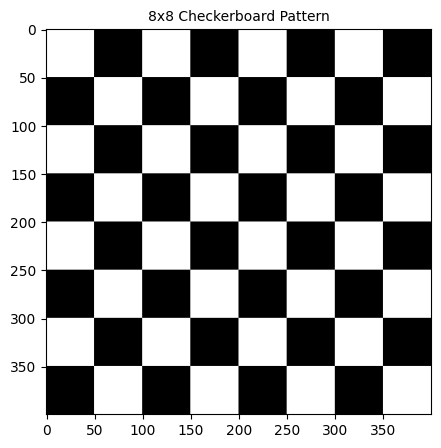

In [ ]:
def generate_checkerboard_pattern(
  rows: int, cols: int, block_size: int
) -> np.ndarray:
  """
  Generate a checkerboard pattern with a specified number of rows and columns.

  Parameters:
    rows (int): Number of rows in the checkerboard.
    cols (int): Number of columns in the checkerboard.
    block_size (int): Size of each block in the checkerboard.

  Returns:
    np.ndarray: Generated checkerboard pattern as a binary image.
  """
  # Create a single black and white 2x2 block
  block = np.zeros((block_size * 2, block_size * 2), dtype=np.uint8)
  block[0:block_size, 0:block_size] = 255
  block[block_size:block_size * 2, block_size:block_size * 2] = 255

  # Tile the block to create the full checkerboard
  checkerboard_pattern = np.tile(block, (rows // 2, cols // 2))

  return checkerboard_pattern

# Parameters
rows, cols = 8, 8   # Number of rows and columns in the checkerboard
block_size = 50     # Size of each block (50x50 pixels)

# Generate a checkerboard pattern
checkerboard_pattern = generate_checkerboard_pattern(rows, cols, block_size)
cv2.imwrite('checker.png', checkerboard_pattern)

# Display the generated checkerboard pattern
plt.figure(figsize=(5, 5))
plt.imshow(checkerboard_pattern, cmap='gray')
plt.title(f'{rows}x{cols} Checkerboard Pattern')
plt.show()

In [ ]:
!wget --user-agent="Mozilla/5.0" https://i.imgur.com/WkKjDqW.jpeg -O texture.jpeg
!wget --user-agent="Mozilla/5.0" https://i.imgur.com/0RcZnZ9.png -O face.png
!wget --user-agent="Mozilla/5.0" https://i.imgur.com/ZfzyOpp.png -O text.png

--2024-12-17 12:59:58--  https://i.imgur.com/WkKjDqW.jpeg
Resolving i.imgur.com (i.imgur.com)... 199.232.192.193, 199.232.196.193
Connecting to i.imgur.com (i.imgur.com)|199.232.192.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151198 (148K) [image/jpeg]
Saving to: ‘texture.jpeg’

texture.jpeg        100%[===================>] 147.65K  --.-KB/s    in 0.03s   

2024-12-17 12:59:58 (5.50 MB/s) - ‘texture.jpeg’ saved [151198/151198]

--2024-12-17 12:59:58--  https://i.imgur.com/0RcZnZ9.png
Resolving i.imgur.com (i.imgur.com)... 199.232.192.193, 199.232.196.193
Connecting to i.imgur.com (i.imgur.com)|199.232.192.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486245 (475K) [image/png]
Saving to: ‘face.png’

face.png            100%[===================>] 474.85K  --.-KB/s    in 0.05s   

2024-12-17 12:59:58 (10.1 MB/s) - ‘face.png’ saved [486245/486245]

--2024-12-17 12:59:58--  https://i.imgur.com/ZfzyOpp.png
Resolving i.imgur.c

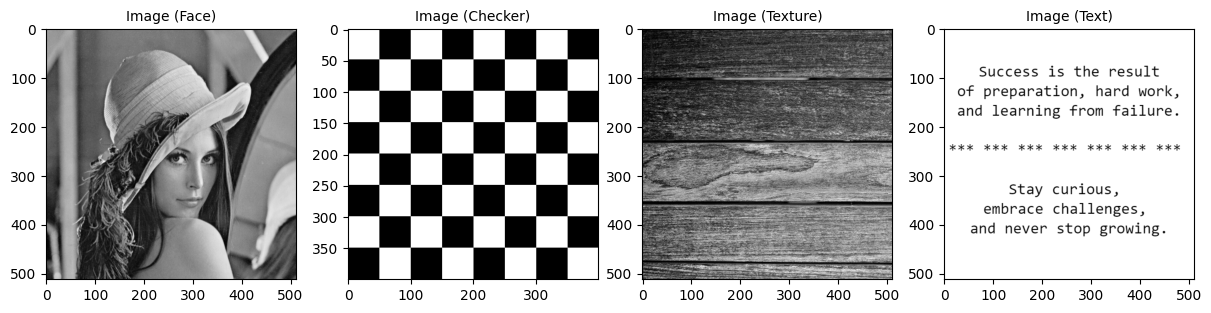

In [ ]:
# Load the images in grayscale
# Store images in a dictionary
images = {
  'face': cv2.imread('face.png', cv2.IMREAD_GRAYSCALE),
  'checker': cv2.imread('checker.png', cv2.IMREAD_GRAYSCALE),
  'texture': cv2.imread('texture.jpeg', cv2.IMREAD_GRAYSCALE),
  'text': cv2.imread('text.png', cv2.IMREAD_GRAYSCALE),
}

# Plot the images
plt.figure(figsize=(3 * len(images), 4), constrained_layout=True)

for idx, (name, image) in enumerate(images.items()):
  plt.subplot(1, len(images), idx + 1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Image ({name.capitalize()})')

plt.show()

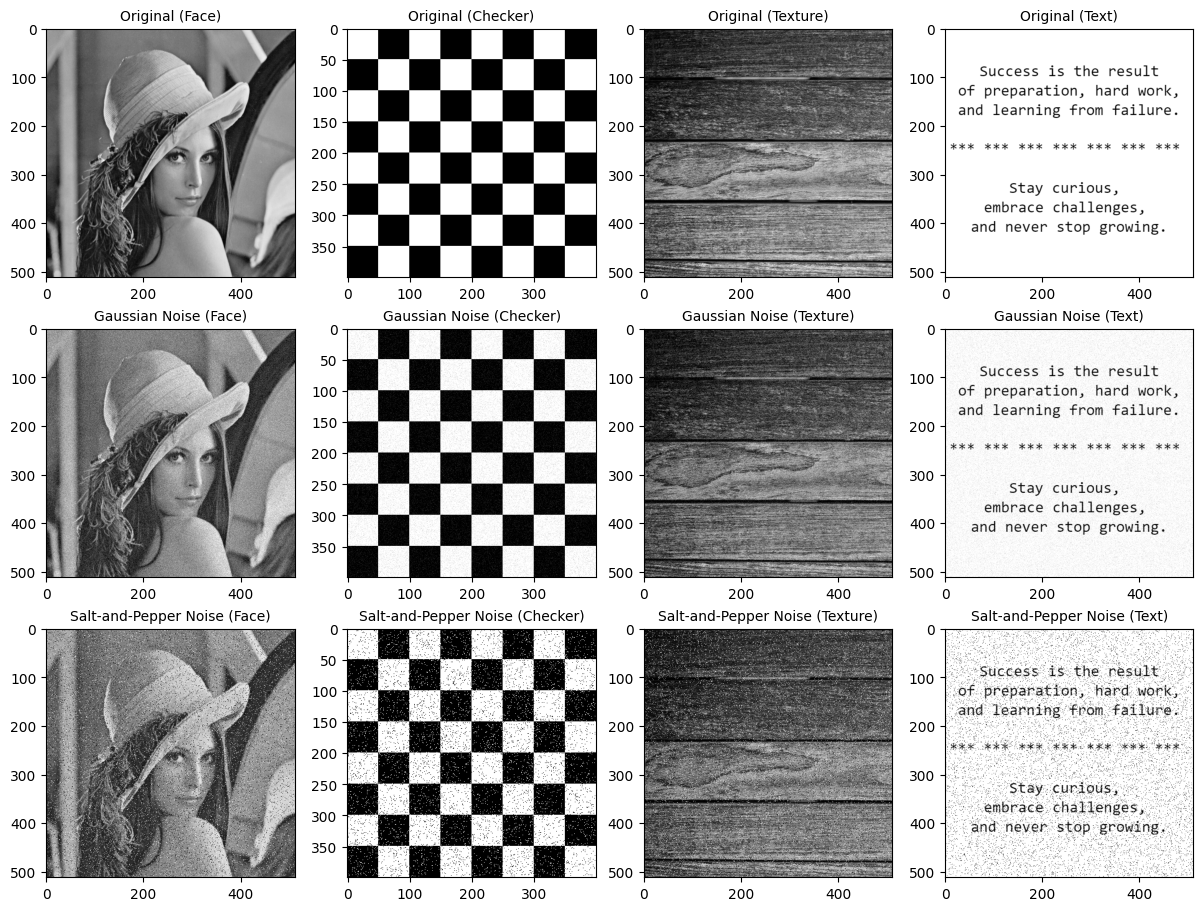

In [ ]:
# Create dictionaries to store the noisy versions of the images
images_gaussian = {}
images_salt_pepper = {}

# Add noise to the images
for name, image in images.items():
  images_gaussian[name] = add_gaussian_noise(image, mean=0, sigma=16)
  images_salt_pepper[name] = add_salt_and_pepper_noise(
    image, salt_prob=0.05, pepper_prob=0.05
  )

# Plot original, Gaussian noisy, and salt-and-pepper noisy images
plt.figure(figsize=(3 * len(images), 3 * 3), constrained_layout=True)

for idx, (name, image) in enumerate(images.items()):
  plt.subplot(3, len(images), idx + 1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Original ({name.capitalize()})')

  plt.subplot(3, len(images), idx + 1 + len(images))
  plt.imshow(images_gaussian[name], cmap='gray')
  plt.title(f'Gaussian Noise ({name.capitalize()})')

  plt.subplot(3, len(images), idx + 1 + 2 * len(images))
  plt.imshow(images_salt_pepper[name], cmap='gray')
  plt.title(f'Salt-and-Pepper Noise ({name.capitalize()})')

plt.show()

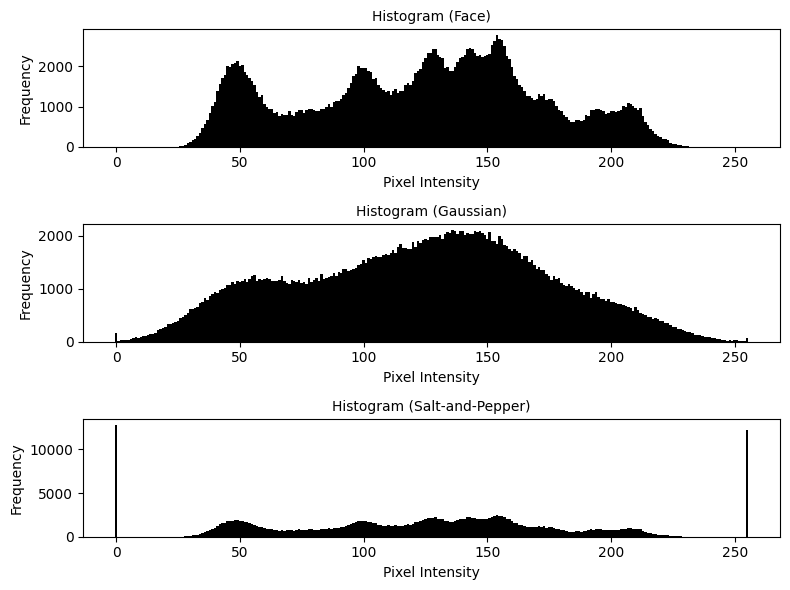

In [ ]:
name = 'face'

plot_histograms(
  images=(images[name], images_gaussian[name], images_salt_pepper[name]),
  titles=[
    f'Histogram ({name.capitalize()})',
    'Histogram (Gaussian)',
    'Histogram (Salt-and-Pepper)'
  ]
)

## 1. Filtering in Spatial Domain

### Linear Filtering (Convolution)

#### Smoothing: Gaussian and Box

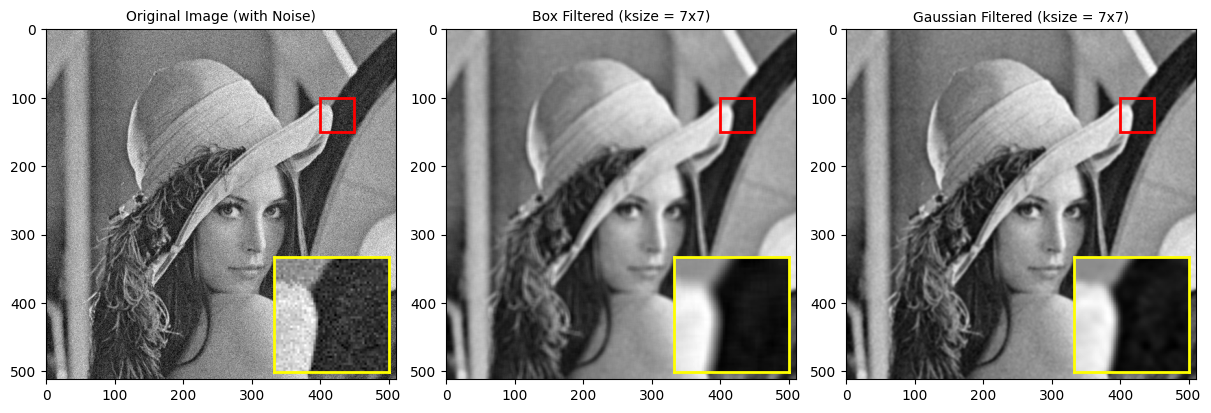

In [ ]:
# Define the kernel size (odd values)
# A: See what happens if you increase the size (e.g., 31x31)
ksize = 7

# Apply the box filter (or mean filter)
image_box_filtered = cv2.blur(images_gaussian['face'], ksize=(ksize, ksize))

# Apply the Gaussian filter
image_gauss_filtered = cv2.GaussianBlur(
  images_gaussian['face'], ksize=(ksize, ksize), sigmaX=0
)

# Display the original and the filtered images
fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 4), constrained_layout=True)

# Coordinates for the zoom window (row start, row end, col start, col end)
rect_coords = 100, 150, 400, 450  # Adjust this region for zoom

axes[0].imshow(images_gaussian['face'], cmap='gray')
axes[0].set_title('Original Image (with Noise)')
add_magnification_effect(images_gaussian['face'], axes[0], *rect_coords)

# Box-filtered image
axes[1].imshow(image_box_filtered, cmap='gray')
axes[1].set_title(f'Box Filtered (ksize = {ksize}x{ksize})')
add_magnification_effect(image_box_filtered, axes[1], *rect_coords)

# Gaussian-filtered image
axes[2].imshow(image_gauss_filtered, cmap='gray')
axes[2].set_title(f'Gaussian Filtered (ksize = {ksize}x{ksize})')
add_magnification_effect(image_gauss_filtered, axes[2], *rect_coords)

plt.show()

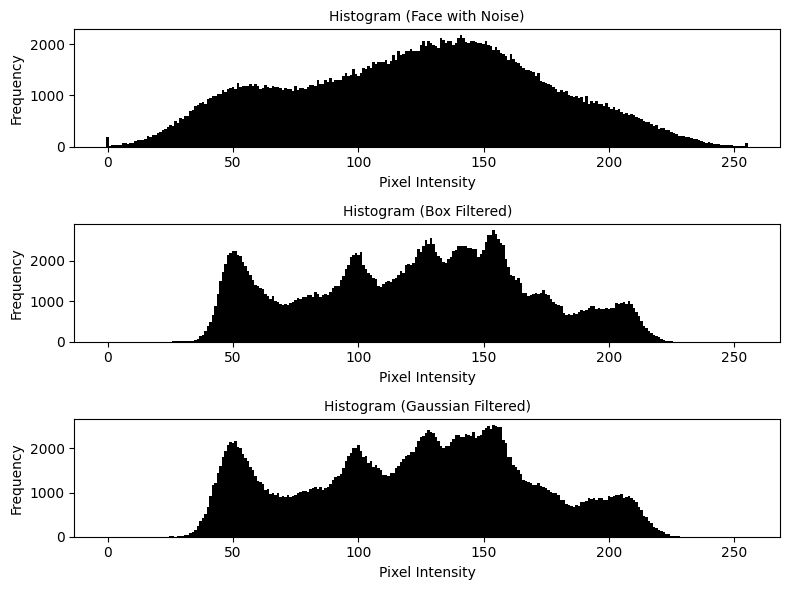

In [ ]:
name = 'face'

plot_histograms(
  images=(images_gaussian[name], image_box_filtered, image_gauss_filtered),
  titles=[
    f'Histogram ({name.capitalize()} with Noise)',
    'Histogram (Box Filtered)',
    'Histogram (Gaussian Filtered)'
  ]
)

Unlike the box filter, the Gaussian filter applies a weighted average, where pixels closer to the center of the kernel have a higher weight.

 The Gaussian filter usually produces smoother results and preserves edges better compared to the box filter.

Changing the standard deviation (sigma) in the Gaussian filter will affect how much smoothing (blurring) is applied to the image:

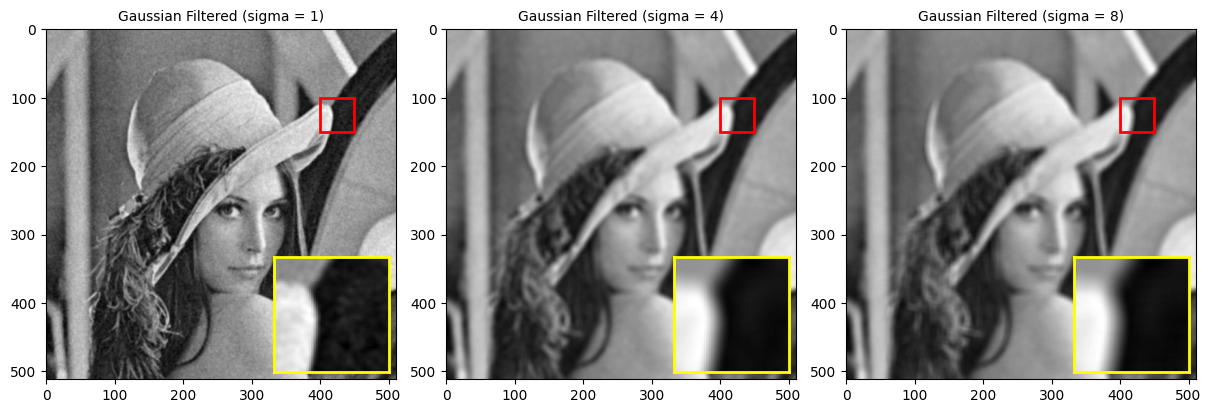

In [ ]:
# Define the kernel size
ksize = 11

# Apply Gaussian Filter with different sigma values
sigmas = [1, 4, 8]

# Apply Gaussian Filter with different sigma values
images_gauss_filtered = np.array([
  cv2.GaussianBlur(images_gaussian['face'], (ksize, ksize), sigma)
    for sigma in sigmas
])

# Display the images
fig, axes = plt.subplots(
  1, len(sigmas), figsize=(4 * len(sigmas), 4),
  constrained_layout=True
)

for idx in range(len(sigmas)):
  axes[idx].imshow(images_gauss_filtered[idx], cmap='gray')
  axes[idx].set_title(f'Gaussian Filtered (sigma = {sigmas[idx]})')
  add_magnification_effect(images_gauss_filtered[idx], axes[idx], *rect_coords)

plt.show()

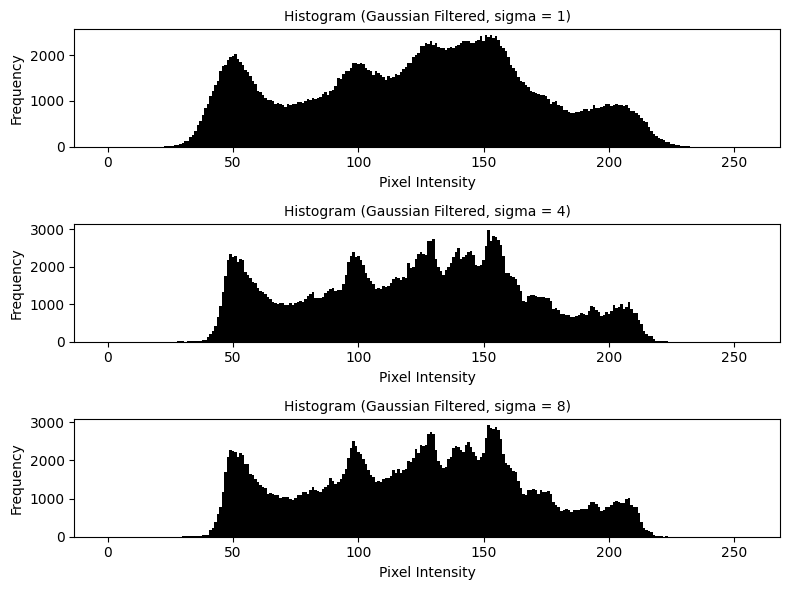

In [ ]:
plot_histograms(
  images=images_gauss_filtered,
  titles=[f'Histogram (Gaussian Filtered, sigma = {sigma})' for sigma in sigmas]
)

As sigma increases, the Gaussian filter starts behaving more like a simple box filter, blurring both edges and the interior of the image uniformly.

#### Sharpening

**Sharpening filters** enhance the edges and fine details in an image by emphasizing transitions between light and dark regions.

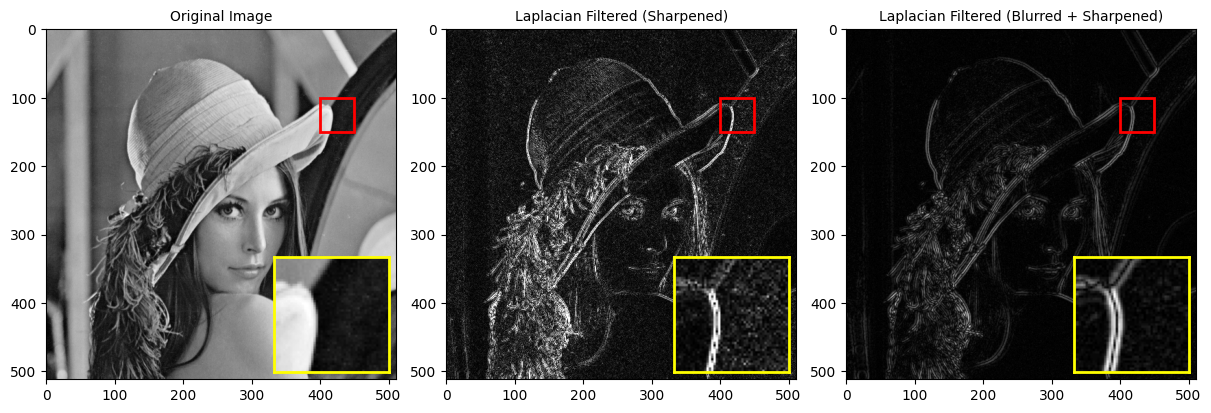

In [ ]:
# Define the kernel size and sigma
ksize = 5
sigma = 0

# Apply Gaussian blur to the image
image_blurred = cv2.GaussianBlur(images['face'], (ksize, ksize), sigma)

# Define the kernel size (used internally for computing the gradients)
laplace_ksize = 3

# Apply Laplacian filter on the original image
image_laplacian = cv2.Laplacian(
  images['face'], ddepth=cv2.CV_64F, ksize=laplace_ksize
)

# Apply Laplacian filter on the blurred image
image_laplacian_blurred = cv2.Laplacian(
  image_blurred, ddepth=cv2.CV_64F, ksize=laplace_ksize
)

# Convert the result back to uint8 type for visualization
image_laplacian = cv2.convertScaleAbs(image_laplacian)
image_laplacian_blurred = cv2.convertScaleAbs(image_laplacian_blurred)

# Display the original and Laplacian-filtered images
fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 4), constrained_layout=True)

axes[0].imshow(images['face'], cmap='gray')
axes[0].set_title('Original Image')
add_magnification_effect(images['face'], axes[0], *rect_coords)

axes[1].imshow(image_laplacian, cmap='gray')
axes[1].set_title('Laplacian Filtered (Sharpened)')
add_magnification_effect(image_laplacian, axes[1], *rect_coords)

axes[2].imshow(image_laplacian_blurred, cmap='gray')
axes[2].set_title('Laplacian Filtered (Blurred + Sharpened)')
add_magnification_effect(image_laplacian_blurred, axes[2], *rect_coords)

plt.show()

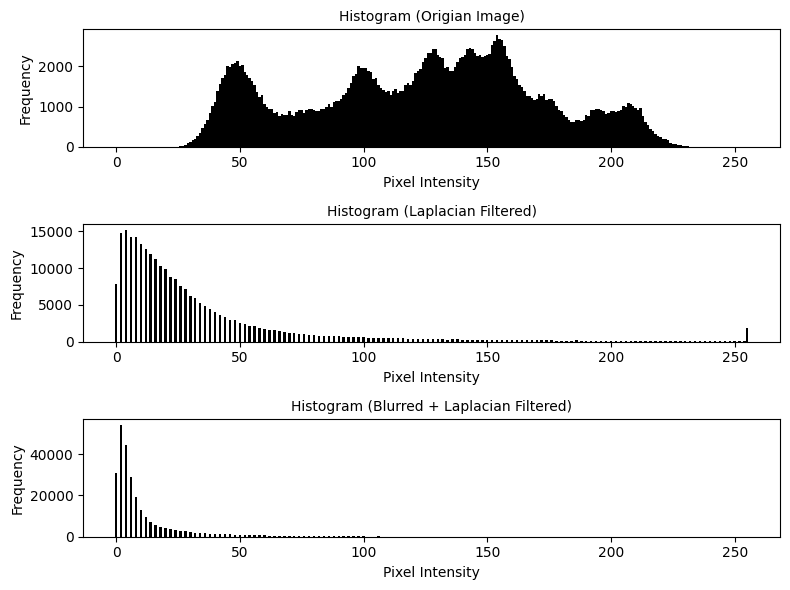

In [ ]:
plot_histograms(
  images=(images['face'], image_laplacian, image_laplacian_blurred),
  titles=[
    'Histogram (Origian Image)',
    'Histogram (Laplacian Filtered)',
    'Histogram (Blurred + Laplacian Filtered)'
  ]
)

#### Unsharping

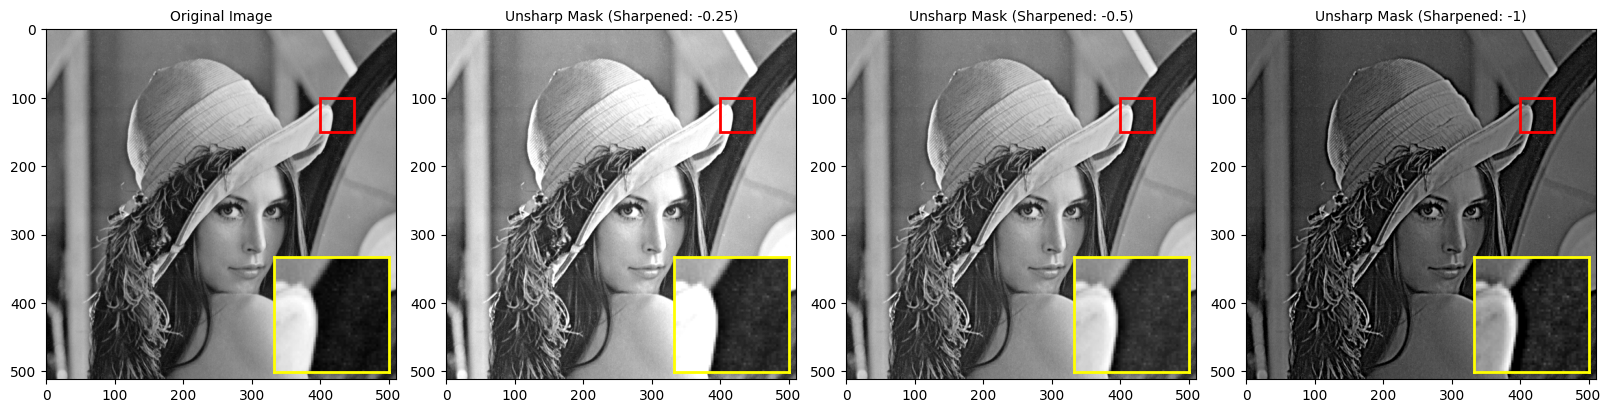

In [ ]:
# Define the kernel size and sigma
ksize = 11
sigma = 5

# Apply Gaussian blur to the image
image_blurred = cv2.GaussianBlur(images['face'], (ksize, ksize), sigma)

# beta: -0.25 => subtle sharpening effect, -1 => more pronounces sharpening
betas = [-0.25, -0.5, -1]

# Unsharp masking: subtract the blurred image from the original
# Formula: Result = alpha * I + beta * I_blurred
unsharp_masks = [
  cv2.addWeighted(
    src1=images['face'], alpha=1.5, src2=image_blurred, beta=beta, gamma=0
  ) for beta in betas
]

# Display the original, blurred, and unsharp mask images
fig, axes = plt.subplots(
  1, len(betas) + 1, figsize=(4 * (len(betas) + 1), 4),
  constrained_layout=True
)

axes[0].imshow(images['face'], cmap='gray')
axes[0].set_title('Original Image')
add_magnification_effect(images['face'], axes[0], *rect_coords)

for idx in range(len(betas)):
  axes[idx + 1].imshow(unsharp_masks[idx], cmap='gray')
  axes[idx + 1].set_title(f'Unsharp Mask (Sharpened: {betas[idx]})')
  add_magnification_effect(unsharp_masks[idx], axes[idx + 1], *rect_coords)

plt.show()

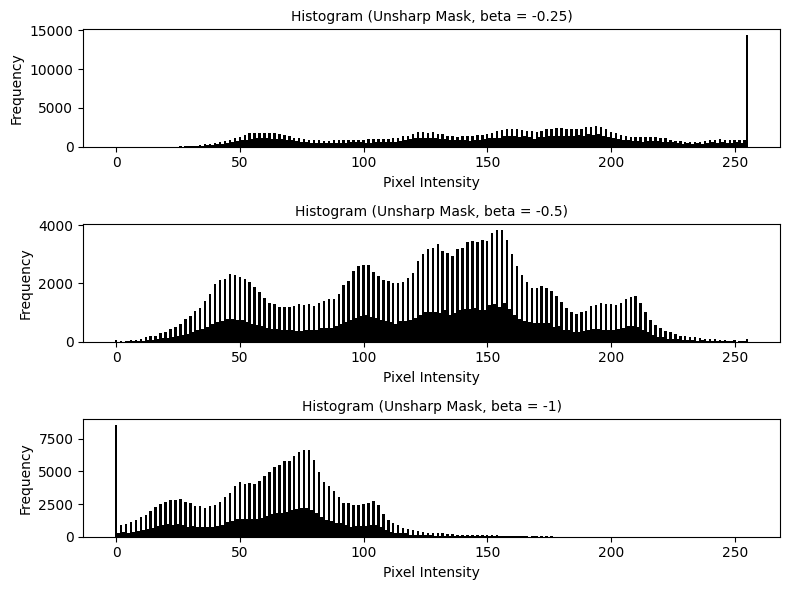

In [ ]:
plot_histograms(
  images=unsharp_masks,
  titles=[f'Histogram (Unsharp Mask, beta = {beta})' for beta in betas]
)

Sharpening filters **can amplify noise** along with edges, especially if the image is noisy to begin with. It's often a good idea to **apply smoothing** (like Gaussian blur) before sharpening.

#### Custom Filtering

To apply **custom filters** in OpenCV, you can use the `cv2.filter2D()` function, which allows you to apply a convolution with any custom kernel (filter). This gives you flexibility to design your own filters for specific tasks like edge detection, sharpening, embossing, etc.

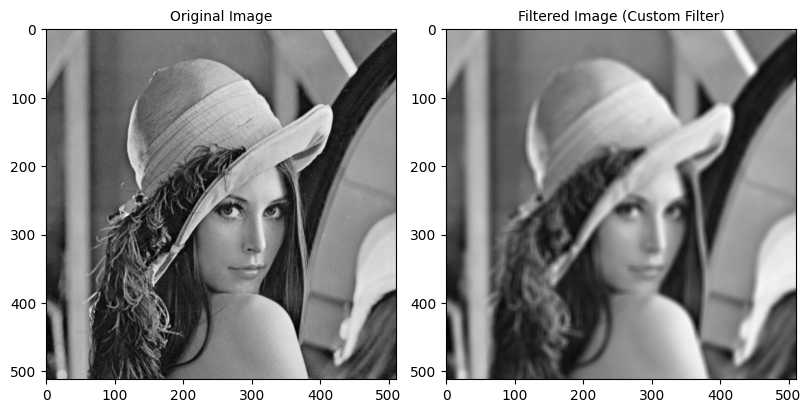

In [ ]:
# Define a custom kernel
custom_kernel = np.ones((9, 9), dtype=np.float64)

# Normaliation (optional for some filters)
custom_kernel /= custom_kernel.sum()

# Apply the custom filter using cv2.filter2D
image_filtered = cv2.filter2D(images['face'], ddepth=-1, kernel=custom_kernel)

# Display the original and filtered images
plt.figure(figsize=(8, 4), constrained_layout=True)

plt.subplot(1, 2, 1)
plt.imshow(images['face'], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image_filtered, cmap='gray')
plt.title('Filtered Image (Custom Filter)')

plt.show()

**Normalize** the kernel when applying smoothing or blurring filters to preserve the brightness or intensity of the image.

**Do not normalize** the kernel for sharpening or edge-detection filters, since these filters focus on detecting changes in intensity rather than preserving the overall brightness.

### Non-linear Filtering

#### Median Filtering

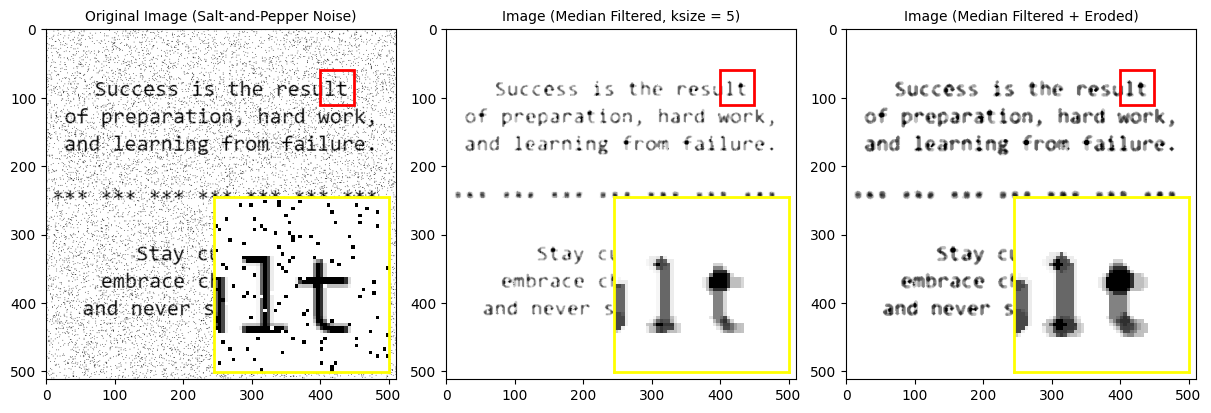

In [ ]:
# Define the kernel size
ksize = 5

# Apply the median filter (removes salt-and-pepper noise)
image_median_filtered = cv2.medianBlur(images_salt_pepper['text'], ksize=ksize)

# Define a morphological kernel for erosion
morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(3, 3))

# Apply erosion after the median filter
image_median_morph = cv2.morphologyEx(
    image_median_filtered, cv2.MORPH_ERODE, morph_kernel, iterations=1
)

# Display the original, median-filtered, and median + eroded images
fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 4), constrained_layout=True)

# Coordinates for the zoom window (adjust based on the image)
rect_coords = 60, 110, 400, 450

axes[0].imshow(images_salt_pepper['text'], cmap='gray')
axes[0].set_title('Original Image (Salt-and-Pepper Noise)')

add_magnification_effect(
  images_salt_pepper['text'], axes[0], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

axes[1].imshow(image_median_filtered, cmap='gray')
axes[1].set_title(f'Image (Median Filtered, ksize = {ksize})')

add_magnification_effect(
  image_median_filtered, axes[1], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

axes[2].imshow(image_median_morph, cmap='gray')
axes[2].set_title('Image (Median Filtered + Eroded)')

add_magnification_effect(
  image_median_morph, axes[2], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

plt.show()

#### Bilateral Filtering

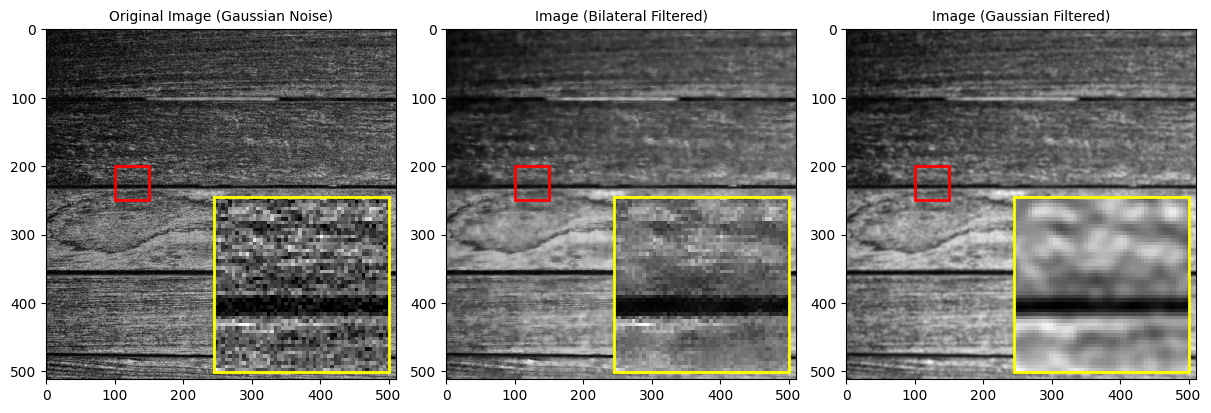

In [ ]:
# Adjust the filter parameters for better effect
d = 9            # Diameter of each pixel neighborhood for bilateral filter
sigmaColor = 50  # Filter sigma in the color space (larger = stronger effect)
sigmaSpace = 50  # Filter sigma in the coordinate space (larger = stronger effect)

# Apply the bilateral filter (edge-preserving filter)
image_bilateral_filtered = cv2.bilateralFilter(
  images_gaussian['texture'], d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace
)

# Apply the Gaussian filter (smoothing filter)
image_gauss_filtered = cv2.GaussianBlur(
  images_gaussian['texture'], ksize=(7, 7), sigmaX=0
)

# Define region coordinates for magnification (adjust based on your image)
rect_coords = (200, 250, 100, 150)

fig, axes = plt.subplots(1, 3, figsize=(3 * 4, 4), constrained_layout=True)

axes[0].imshow(images_gaussian['texture'], cmap='gray')
axes[0].set_title('Original Image (Gaussian Noise)')

add_magnification_effect(
  images_gaussian['texture'], axes[0], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

axes[1].imshow(image_bilateral_filtered, cmap='gray')
axes[1].set_title('Image (Bilateral Filtered)')

add_magnification_effect(
  image_bilateral_filtered, axes[1], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

axes[2].imshow(image_gauss_filtered, cmap='gray')
axes[2].set_title('Image (Gaussian Filtered)')

add_magnification_effect(
  image_gauss_filtered, axes[2], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

plt.show()

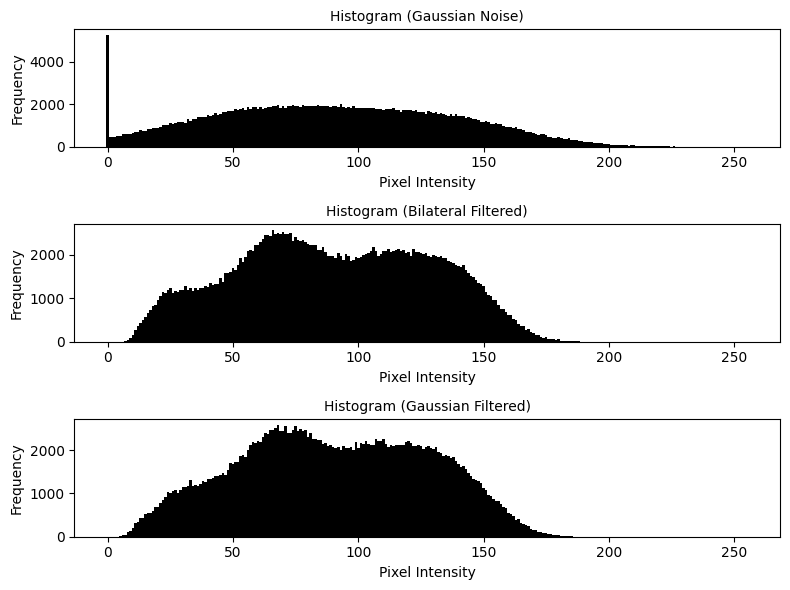

In [ ]:
plot_histograms(
  images=(
    images_gaussian['texture'],
    image_bilateral_filtered,
    image_gauss_filtered
  ),
  titles=[
    'Histogram (Gaussian Noise)',
    'Histogram (Bilateral Filtered)',
    'Histogram (Gaussian Filtered)'
  ]
)

#### Non-Local Means Filtering

The **Non-Local Means Filter** works by averaging pixel values based on their similarity to neighboring pixels, rather than their closeness. It calculates the mean of similar pixel values in a large window.

Excellent for **denoising** while maintaining details and texture, especially in medical imaging and photography.

In [ ]:
# Apply the non-local means filter
image_denoised = cv2.fastNlMeansDenoising(
    images_gaussian['text'], h=16, templateWindowSize=7, searchWindowSize=21
)

# Define region coordinates for magnification (adjust based on your image)
rect_coords = (100, 150, 400, 450)

fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 4), constrained_layout=True)

axes[0].imshow(images_gaussian['text'], cmap='gray')
axes[0].set_title('Original Image (Gaussian Noise)')

add_magnification_effect(
  images_gaussian['text'], axes[0], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

axes[1].imshow(image_denoised, cmap='gray')
axes[1].set_title('Image (Non-local Means Filtered)')

add_magnification_effect(
  image_denoised, axes[1], *rect_coords,
  zoom_width='50%', zoom_height='50%'
)

plt.show()

NameError: name 'images_gaussian' is not defined

**Median Filtering with Morphological Operations**: Median filtering followed by opening or closing operations can enhance the removal of specific noise types.

**Edge-Preserving Noise Removal**: Use the bilateral filter for denoising images, followed by sharpening filters to improve the edge details.

## 2. Frequency Domain

### Discrete Fourier Transform

#### Playground

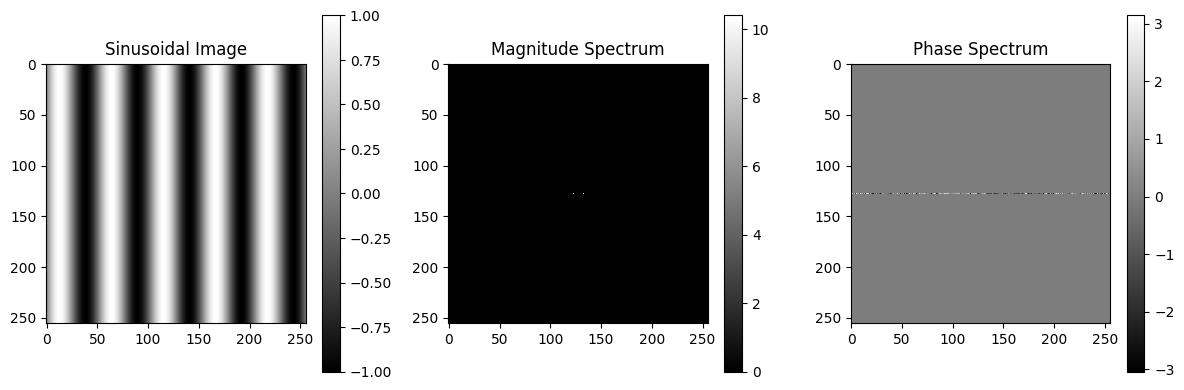

In [ ]:
# Function to generate a sinusoidal image
def generate_sinusoidal(rows, cols, freq_x, freq_y, amplitude=1, phase=0):
  """
  Generate a 2D sinusoidal image.

  Parameters:
  - rows: Number of rows in the image.
  - cols: Number of columns in the image.
  - freq_x: Horizontal frequency (cycles per image width).
  - freq_y: Vertical frequency (cycles per image height).
  - amplitude: Amplitude of the sinusoid.
  - phase: Phase shift in radians.

  Returns:
  - 2D array representing the sinusoidal image.
  """
  X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
  return amplitude * np.sin(2 * np.pi * (freq_x * X / cols + freq_y * Y / rows) + phase)

# Parameters for sinusoidal image
rows, cols = 256, 256
freq_x = 5    # Horizontal frequency (cycles per image width)
freq_y = 0    # Vertical frequency (cycles per image height)
amplitude = 1 # contrast or strength
phase = 0     # in radians

# Generate a sinusoidal image
sinusoidal_image = generate_sinusoidal(rows, cols, freq_x, freq_y, amplitude, phase)

# Perform Fourier Transform
dft = np.fft.fft2(sinusoidal_image)
dft_shifted = np.fft.fftshift(dft)
magnitude_spectrum = np.log1p(np.abs(dft_shifted))
phase_spectrum = np.angle(dft_shifted)

# Plotting
plt.figure(figsize=(12, 4))

# Sinusoidal Image
plt.subplot(1, 3, 1)
plt.title("Sinusoidal Image")
plt.imshow(sinusoidal_image, cmap='gray')
plt.colorbar()

# Magnitude Spectrum
plt.subplot(1, 3, 2)
plt.title("Magnitude Spectrum")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.colorbar()

# Phase Spectrum
plt.subplot(1, 3, 3)
plt.title("Phase Spectrum")
plt.imshow(phase_spectrum, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

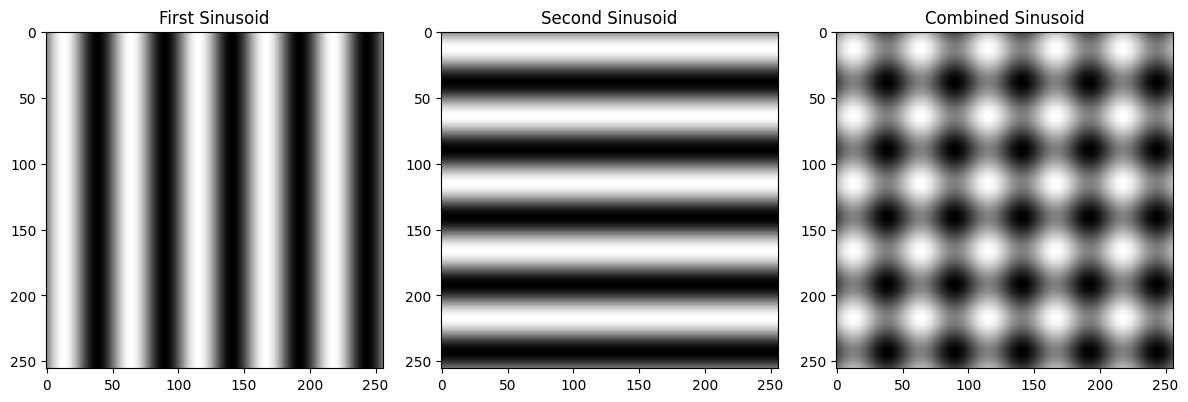

In [ ]:
# Parameters for the 1st sinusoid
rows, cols = 256, 256
freq_x1, freq_y1 = 5, 0
amplitude1, phase1 = 1, 0

# Parameters for the 2nd sinusoid
freq_x2, freq_y2 = 0, 5
amplitude2, phase2 = 1, 0

# Generate the sinusoids
sinusoid1 = generate_sinusoidal(rows, cols, freq_x1, freq_y1, amplitude1, phase1)
sinusoid2 = generate_sinusoidal(rows, cols, freq_x2, freq_y2, amplitude2, phase2)

# Combine the two sinusoids
combined_sinusoid = sinusoid1 + sinusoid2

# Plot the results
plt.figure(figsize=(12, 6))

# First Sinusoid
plt.subplot(1, 3, 1)
plt.title("First Sinusoid")
plt.imshow(sinusoid1, cmap='gray')

# Second Sinusoid
plt.subplot(1, 3, 2)
plt.title("Second Sinusoid")
plt.imshow(sinusoid2, cmap='gray')

# Combined Sinusoid
plt.subplot(1, 3, 3)
plt.title("Combined Sinusoid")
plt.imshow(combined_sinusoid, cmap='gray')

plt.tight_layout()
plt.show()

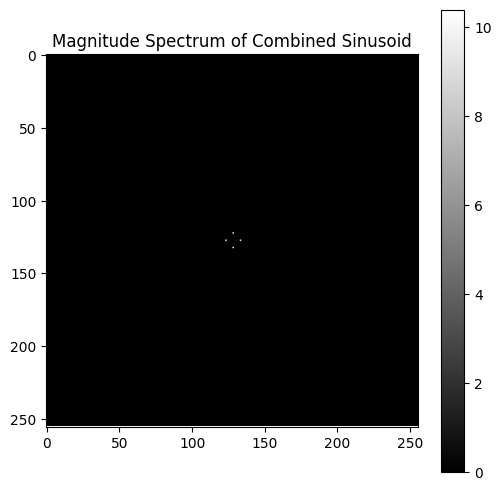

In [ ]:
# Fourier Transform of the combined sinusoid
dft = np.fft.fft2(combined_sinusoid)
dft_shifted = np.fft.fftshift(dft)
magnitude_spectrum = np.log1p(np.abs(dft_shifted))

# Plot the magnitude spectrum
plt.figure(figsize=(6, 6))
plt.title("Magnitude Spectrum of Combined Sinusoid")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.colorbar()
plt.show()

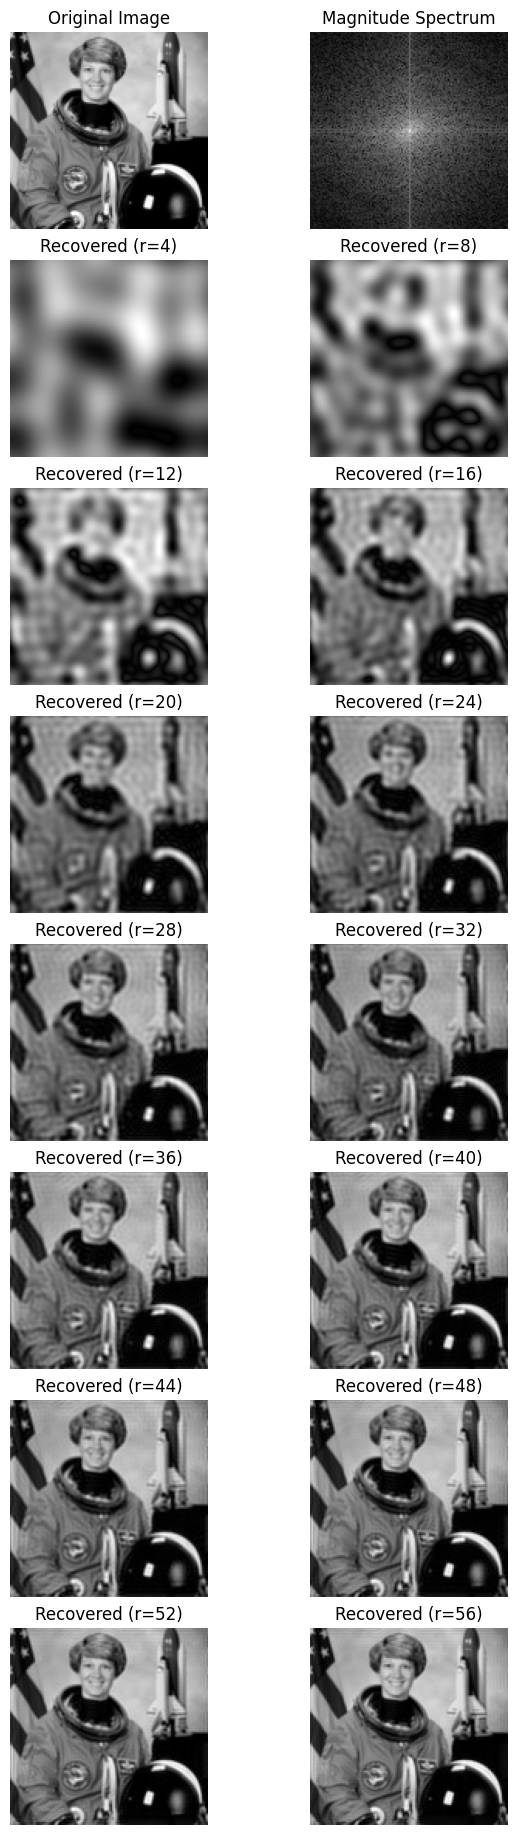

In [ ]:
from skimage import data, color
from skimage.transform import resize
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Load and preprocess the grayscale image
image = color.rgb2gray(data.astronaut())  # Convert to grayscale
image = resize(image, (128, 128))         # Resize for simplicity

# Compute the Fourier Transform and its shifted magnitude spectrum
fft_image = fft2(image)
fft_shifted = fftshift(fft_image)
magnitude_spectrum = np.log1p(np.abs(fft_shifted))

# Set up the plot with constrained_layout
rows, cols = image.shape
step_size = 4  # Step size for radius
max_radius = min(rows, cols) // 2

# Calculate the number of recovered images based on the step size
num_recovered_images = (max_radius // step_size)

fig, axes = plt.subplots(num_recovered_images + 1, 2, figsize=(3 * 2, 4 * (num_recovered_images // 2 + 1)), constrained_layout=True)

# First row: original image and magnitude spectrum
axes[0, 0].imshow(image, cmap="gray")
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(magnitude_spectrum, cmap="gray")
axes[0, 1].set_title("Magnitude Spectrum")
axes[0, 1].axis("off")

# Iterative recovery from low to high frequencies
center = (cols // 2, rows // 2)  # Center of the image

recovered_images = []
for radius in range(step_size, max_radius, step_size):
    # Create a circular mask using OpenCV
    mask = np.zeros((rows, cols), dtype=np.float32)
    cv2.circle(mask, center, radius, 1, thickness=-1)  # Draw filled circle

    # Apply the mask to the shifted FFT and recover the image
    filtered_fft = fft_shifted * mask
    recovered_image = np.abs(ifft2(ifftshift(filtered_fft)))
    recovered_images.append((radius, recovered_image))

# Display intermediate reconstructions in subsequent rows (from left to right)
for i, (radius, recovered_image) in enumerate(recovered_images[:num_recovered_images]):
    row = (i // 2) + 1  # Determine the row (0-based index)
    col = (i % 2)       # Determine the column (0 or 1)

    axes[row, col].imshow(recovered_image, cmap="gray")
    axes[row, col].set_title(f"Recovered (r={radius})")
    axes[row, col].axis("off")

# Remove unused axes if any
for i in range(num_recovered_images, len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.show()

#### DFT and Inverse DFT

In [ ]:
def fft2d(
  image: np.ndarray, magnitude_scaled: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """
  Perform a 2D Fast Fourier Transform (FFT) on a grayscale image
    and return the magnitude and phase spectra.

  Parameters:
  -----------
  image : np.ndarray
    The input image as a 2D NumPy array (grayscale).
  magnitude_scaled : bool, optional, default=True
    If True, applies logarithmic scaling to the magnitude spectrum
      to enhance visualization.
    Logarithmic scaling helps highlight low-frequency components.

  Returns:
  --------
  magnitude : np.ndarray
    The magnitude spectrum of the 2D FFT,
      either scaled (logarithmic) or unscaled based on the parameter.
  phase : np.ndarray
    The phase spectrum of the 2D FFT.
  image_fft_shifted : np.ndarray
    The resulting 2D FFT image with zero frequency shifted to the center.
  """
  # Perform 2D Fourier Transform
  image_fft = np.fft.fft2(image)

  # Shift the zero frequency component to the center
  image_fft_shifted = np.fft.fftshift(image_fft)

  # Compute the magnitude and phase
  magnitude = np.abs(image_fft_shifted)  # absolute values of complex numbers
  phase = np.angle(image_fft_shifted)    # phase (angle of complex numbers)

  # Apply logarithmic scaling to the magnitude if needed
  if magnitude_scaled:
    magnitude = np.log1p(magnitude)

  return magnitude, phase, image_fft_shifted

In [ ]:
def ifft2d(image_fft: np.ndarray) -> np.ndarray:
  # Shift the zero frequency component back to the corners
  image_fft_shifted = np.fft.ifftshift(image_fft)

  # Perform the inverse FFT to get back the spatial domain image
  image = np.fft.ifft2(image_fft_shifted)

  # Take the real part of the result (since the imaginary part should be negligible)
  return cv2.convertScaleAbs(image.real)

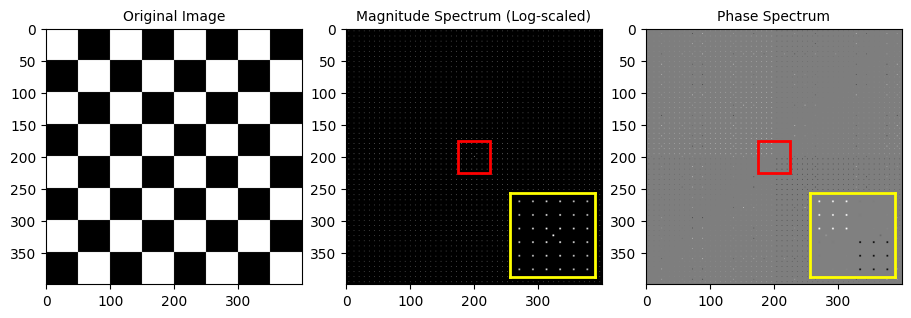

In [ ]:
# Choose the target image
image = images['checker']

magnitude_scaled, phase, _ = fft2d(image, magnitude_scaled=True)

# Define coordinates for magnification effect
height, width = image.shape
rect_coords = (width//2 - 25, width//2 + 25, height//2 - 25, height//2 + 25)

# Plot the original image, log-scaled magnitude spectrum, and phase spectrum
fig, axes = plt.subplots(1, 3, figsize=(3 * 3, 3), constrained_layout=True)

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(magnitude_scaled, cmap='gray')
axes[1].set_title('Magnitude Spectrum (Log-scaled)')
add_magnification_effect(magnitude_scaled, axes[1], *rect_coords)

axes[2].imshow(phase, cmap='gray')
axes[2].set_title('Phase Spectrum')
add_magnification_effect(phase, axes[2], *rect_coords)

plt.show()

**Magnitude** describes **how much** of a certain frequency is present in the image. It reveals the intensity of various frequency components (low or high frequencies). The **intensity in the magnitude** spectrum indicates the strength of a particular frequency. Brighter areas mean that those frequencies contribute more to the image.

**Phase** describes the **position or shift** of those frequencies. The phase helps to reconstruct the actual structure of the image (i.e., how the pixels are arranged spatially).

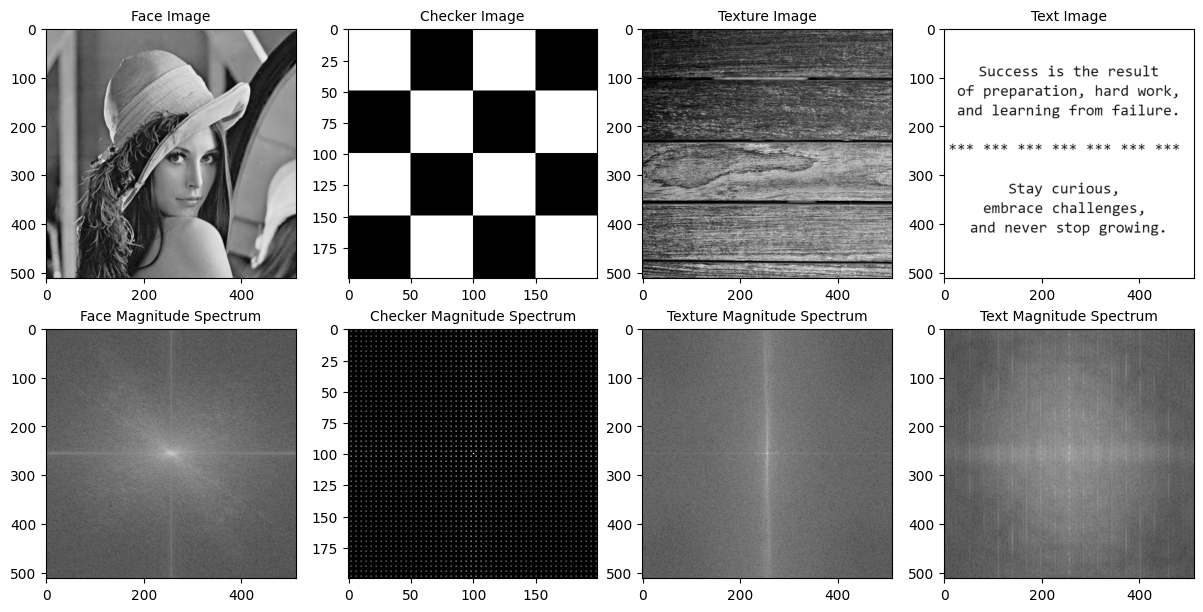

In [ ]:
fig, axes = plt.subplots(
  2, len(images), figsize=(3 * len(images), 3 * 2),
  constrained_layout=True
)

for idx, (name, image) in enumerate(images.items()):
  # Compute the magnitude and phase (log-scaled magnitude is enabled)
  magnitude, _, _ = fft2d(image, magnitude_scaled=True)

  # Plot the original image (spatial domain)
  axes[0, idx].imshow(image, cmap='gray')
  axes[0, idx].set_title(f'{name.capitalize()} Image')

  # Plot the magnitude spectrum (log-scaled)
  axes[1, idx].imshow(magnitude, cmap='gray')
  axes[1, idx].set_title(f'{name.capitalize()} Magnitude Spectrum')

plt.show()

**Face Image**:
- The magnitude spectrum shows a **bright spot at the center**, which represents the low-frequency components of the image (the general structure of the face).
- The **gradual falloff from the center** indicates that the image has mostly low-frequency content, as expected from natural images.
- The **small details and textures** (like hair) introduce some higher frequency components, but they **are less dominant** compared to the overall shape.

**Checkerboard Image**:
- The magnitude spectrum has a very distinct pattern, with **regularly spaced bright spots** away from the center.
- This pattern indicates the presence of **strong, repetitive high-frequency components**, which are characteristic of the sharp edges and alternating black and white squares in the checkerboard.
- The **regular spacing** reflects the periodicity of the squares in the checkerboard pattern.

**Texture Image**:
- The spectrum shows a** bright vertical and horizontal line** intersecting at the center, which indicates **strong low-frequency content** in the image.
- The lines suggest that the image has **structured patterns** in both horizontal and vertical directions (grain in the wood).

**Text Image**:
- The magnitude spectrum displays **vertical streaks** that indicate strong vertical structure in the image. The lines of text are aligned horizontally, producing vertical patterns in the frequency domain.
- The magnitude spectrum has more **concentrated low-frequency components at the center**, with some spread toward higher frequencies corresponding to the sharp edges of the letters in the text.

Max absolute pixel diff: 0
Mean absolute pixel diff: 0.0


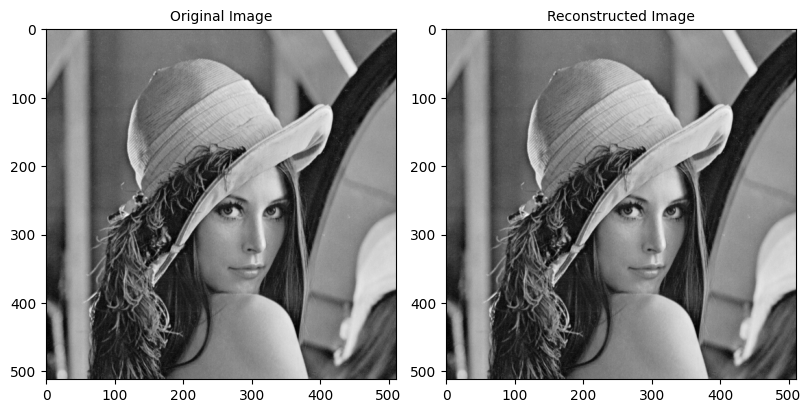

In [ ]:
image = images['face']

# Perform Fourier Transform to get magnitude and phase
_, _, image_fft = fft2d(image)

# Reconstruct the image
image_reconstructed = ifft2d(image_fft)

# Compute and print the maximum and mean pixel differences
max_diff = np.max(np.abs(image_reconstructed - image))
mean_diff = np.mean(np.abs(image_reconstructed - image))

print(f'Max absolute pixel diff: {max_diff}')
print(f'Mean absolute pixel diff: {mean_diff}')

# Display the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 4), constrained_layout=True)

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(image_reconstructed, cmap='gray')
axes[1].set_title('Reconstructed Image')

plt.show()

## 3. Filtering in Frequency Domain

In [ ]:
# Choose the target image
image = images['face']

# Perform Fourier Transform to get magnitude and phase
magnitude_scaled, phase, image_fft = fft2d(image, magnitude_scaled=True)

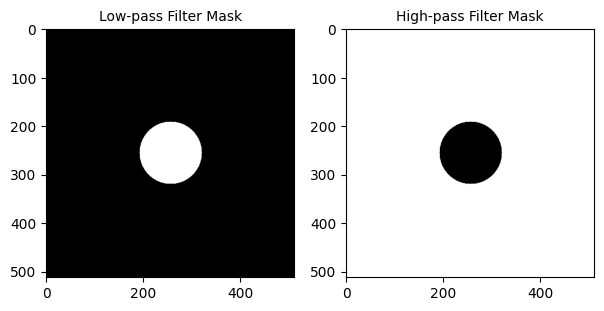

In [ ]:
# Create a mask for filtering low frequencies (center frequencies)
mask_size = 64
mask_height, mask_width = image_fft.shape

# Create a blank mask (same shape as the image)
mask = np.zeros(image_fft.shape, np.float64)

# Create a circular mask in the center of the frequency domain
cv2.circle(
  mask, center=(mask_width//2, mask_height//2),
  radius=mask_size, color=1, thickness=-1, lineType=cv2.LINE_AA
)

# Inverse the mask (to filter out high frequencies instead of low frequencies)
mask_inv = 1 - mask

plt.figure(figsize=(3 * 2, 3), constrained_layout=True)

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray', vmax=1)
plt.title('Low-pass Filter Mask')

plt.subplot(1, 2, 2)
plt.imshow(mask_inv, cmap='gray', vmax=1)
plt.title('High-pass Filter Mask')

plt.show()

### Low-pass and High-pass Filtering

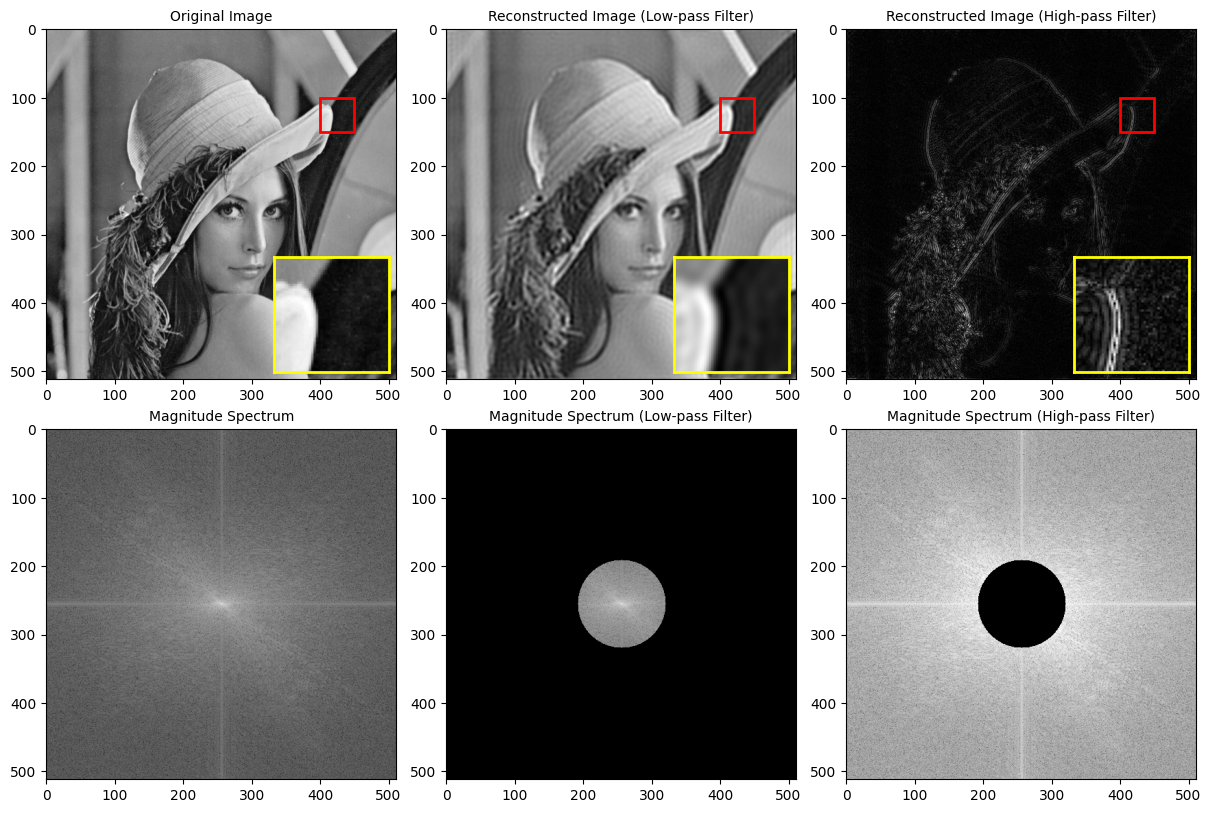

In [ ]:
# Apply the mask on the image (for low-pass filtering)
image_fft_low_pass = image_fft * mask
magnitude_scaled_low_pass = np.log1p(np.abs(image_fft_low_pass))

# Apply the inverted mask on the image (for high-pass filtering)
image_fft_high_pass = image_fft * mask_inv
magnitude_scaled_high_pass = np.log1p(np.abs(image_fft_high_pass))

# Perform inverse FFT on the masked spectrum to reconstruct the image
image_low_pass = ifft2d(image_fft_low_pass)
image_high_pass = ifft2d(image_fft_high_pass)

rect_coords = (100, 150, 400, 450)

# Visualize the original image, magnitude spectrum, and masked results
fig, axes = plt.subplots(2, 3, figsize=(3 * 4, 2 * 4), constrained_layout=True)

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')

add_magnification_effect(image, axes[0, 0], *rect_coords)

axes[1, 0].imshow(magnitude_scaled, cmap='gray')
axes[1, 0].set_title('Magnitude Spectrum')

# Low-pass Filter
axes[0, 1].imshow(image_low_pass, cmap='gray')
axes[0, 1].set_title('Reconstructed Image (Low-pass Filter)')

add_magnification_effect(image_low_pass, axes[0, 1], *rect_coords)

axes[1, 1].imshow(magnitude_scaled_low_pass, cmap='gray')
axes[1, 1].set_title('Magnitude Spectrum (Low-pass Filter)')

# High-pass Filter
axes[0, 2].imshow(image_high_pass, cmap='gray')
axes[0, 2].set_title('Reconstructed Image (High-pass Filter)')

add_magnification_effect(image_high_pass, axes[0, 2], *rect_coords)

axes[1, 2].imshow(magnitude_scaled_high_pass, cmap='gray')
axes[1, 2].set_title('Magnitude Spectrum (High-pass Filter)')

plt.show()

#### Box and Gaussian

In [ ]:
# Define the kernel size and image size
ksize = 9
sigma = 0

# Get image dimensions
height, width = image.shape

# Create a Box filter kernel (all ones)
box_kernel = np.ones((ksize, ksize), dtype=np.float64) / (ksize * ksize)

# Create a Gaussian filter kernel
gauss_kernel = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)  # 1D Gaussian kernel
gauss_kernel = gauss_kernel * gauss_kernel.T  # Convert to 2D by outer product

# Pad the Box filter to the size of the original image
box_kernel_padded = np.pad(
  box_kernel, ((0, height - ksize), (0, width - ksize)),
  mode='constant'
)

# Pad the Gaussian filter to the size of the original image
gauss_kernel_padded = np.pad(
  gauss_kernel, ((0, height - ksize), (0, width - ksize)),
  mode='constant'
)

box_kernel_padded = np.fft.fftshift(box_kernel_padded)
gauss_kernel_padded = np.fft.fftshift(gauss_kernel_padded)

print(f'Shape (image): {image.shape}')
print(f'Shape (box kernel): {box_kernel_padded.shape}')
print(f'Shape (gauss kernel): {gauss_kernel_padded.shape}')

Shape (image): (512, 512)
Shape (box kernel): (512, 512)
Shape (gauss kernel): (512, 512)


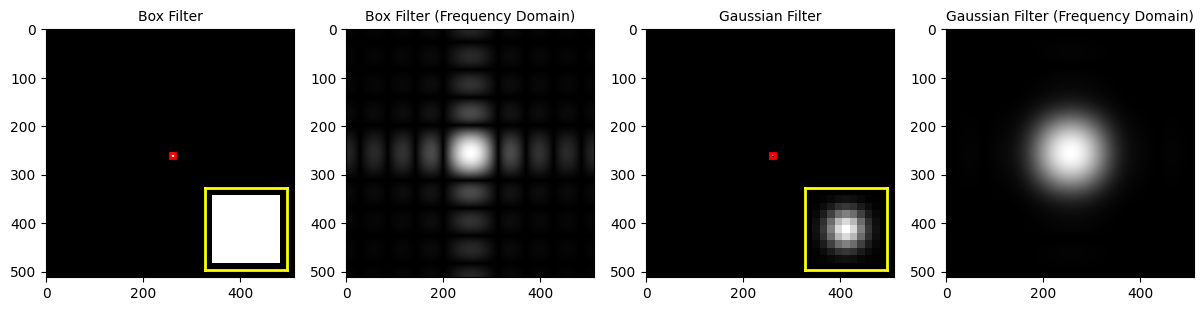

In [ ]:
# Perform FFT and scale the magnitude for visualization (log-scaled magnitude)
box_magnitude_scaled, _, box_fft = fft2d(box_kernel_padded)
gauss_magnitude_scaled, _, gauss_fft = fft2d(gauss_kernel_padded)

# Define coordinates for magnification effect (zoom into the kernel region)
rect_coords = (
  width//2 - 1, width//2 + ksize + 1,
  height//2 - 1, height//2 + ksize + 1
)

# Create subplots to visualize the kernels and their frequency domain representations
fig, axes = plt.subplots(1, 4, figsize=(3 * 4, 4), constrained_layout=True)

axes[0].imshow(box_kernel_padded, cmap='gray')
axes[0].set_title('Box Filter')
add_magnification_effect(box_kernel_padded, axes[0], *rect_coords)

axes[1].imshow(box_magnitude_scaled, cmap='gray')
axes[1].set_title('Box Filter (Frequency Domain)')

axes[2].imshow(gauss_kernel_padded, cmap='gray')
axes[2].set_title('Gaussian Filter')
add_magnification_effect(gauss_kernel_padded, axes[2], *rect_coords)

axes[3].imshow(gauss_magnitude_scaled, cmap='gray')
axes[3].set_title('Gaussian Filter (Frequency Domain)')

plt.show()

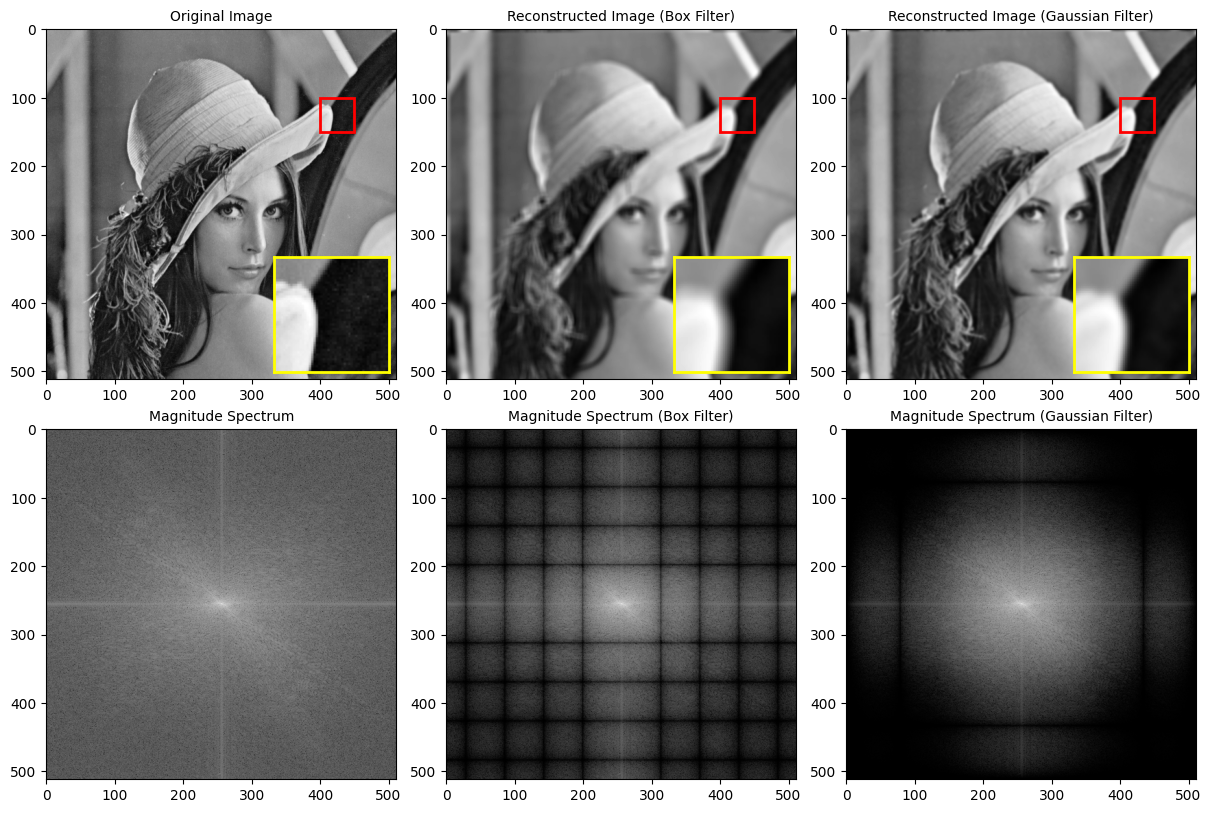

In [ ]:
# Apply the kernels on the image
image_fft_box = image_fft * box_fft
magnitude_scaled_box = np.log1p(np.abs(image_fft_box))

image_fft_gauss = image_fft * gauss_fft
magnitude_scaled_gauss = np.log1p(np.abs(image_fft_gauss))

# Perform inverse FFT on the masked spectrum to reconstruct the image
image_box = ifft2d(image_fft_box)
image_gauss = ifft2d(image_fft_gauss)

image_box = np.fft.ifftshift(image_box)
image_gauss = np.fft.ifftshift(image_gauss)

rect_coords = (100, 150, 400, 450)

# Visualize the original image, magnitude spectrum, and masked results
fig, axes = plt.subplots(2, 3, figsize=(3 * 4, 2 * 4), constrained_layout=True)

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')

add_magnification_effect(image, axes[0, 0], *rect_coords)

axes[1, 0].imshow(magnitude_scaled, cmap='gray')
axes[1, 0].set_title('Magnitude Spectrum')

# Low-pass Filter
axes[0, 1].imshow(image_box, cmap='gray')
axes[0, 1].set_title('Reconstructed Image (Box Filter)')

add_magnification_effect(image_box, axes[0, 1], *rect_coords)

axes[1, 1].imshow(magnitude_scaled_box, cmap='gray')
axes[1, 1].set_title('Magnitude Spectrum (Box Filter)')

# High-pass Filter
axes[0, 2].imshow(image_gauss, cmap='gray')
axes[0, 2].set_title('Reconstructed Image (Gaussian Filter)')

add_magnification_effect(image_gauss, axes[0, 2], *rect_coords)

axes[1, 2].imshow(magnitude_scaled_gauss, cmap='gray')
axes[1, 2].set_title('Magnitude Spectrum (Gaussian Filter)')

plt.show()

## 4. Image Pyramids

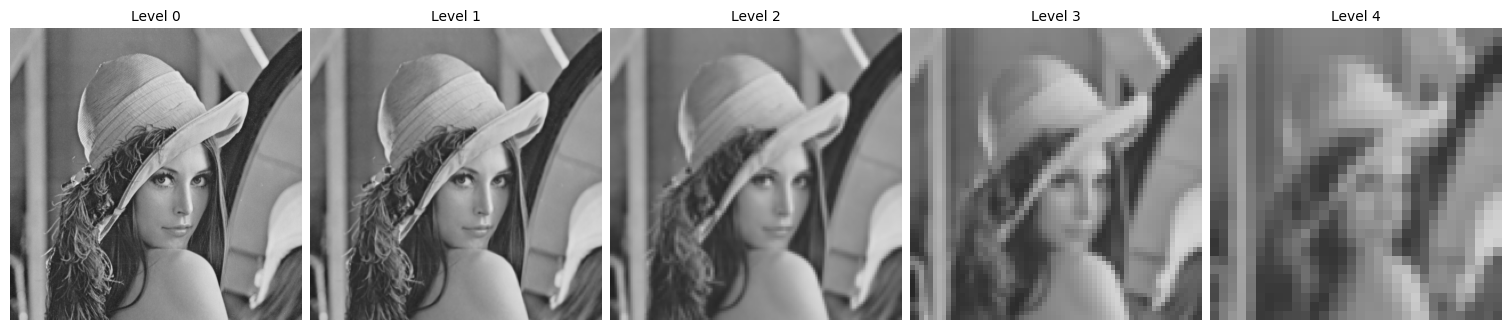

In [ ]:
image = images['face']

gaussian_pyr = [image]
num_levels = 5

for level in range(num_levels - 1):
  image = cv2.pyrDown(image)
  gaussian_pyr.append(image)

plt.figure(figsize=(num_levels * 3, 4), constrained_layout=True)

for level, layer in enumerate(gaussian_pyr):
  plt.subplot(1, num_levels, level + 1)
  plt.imshow(cv2.cvtColor(layer, cv2.COLOR_BGR2RGB))
  plt.title(f'Level {level}')
  plt.axis('off')

plt.show()

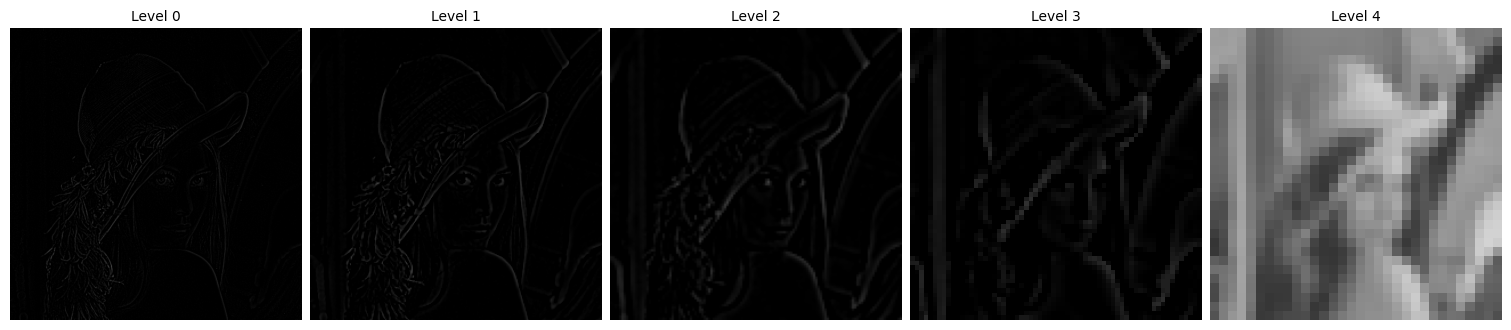

In [ ]:
laplacian_pyr = []

for level in range(len(gaussian_pyr) - 1):
  # Upsample the next level of Gaussian pyramid
  gaussian_up = cv2.pyrUp(gaussian_pyr[level + 1])

  # Resize the upsampled image to match the current Gaussian level size
  gaussian_up_resized = cv2.resize(gaussian_up, (gaussian_pyr[level].shape[1], gaussian_pyr[level].shape[0]))

  # Subtract the upsampled image from the current Gaussian pyramid image to get the Laplacian layer
  laplacian = cv2.subtract(gaussian_pyr[level], gaussian_up_resized)
  laplacian_pyr.append(laplacian)

# Append the last level of Gaussian pyramid as the final layer of the Laplacian pyramid
laplacian_pyr.append(gaussian_pyr[-1])

plt.figure(figsize=(num_levels * 3, 4), constrained_layout=True)

for level, layer in enumerate(laplacian_pyr):
  plt.subplot(1, num_levels, level + 1)
  plt.imshow(cv2.cvtColor(layer, cv2.COLOR_BGR2RGB))
  plt.title(f'Level {level}')
  plt.axis('off')

plt.show()